# Testing
### Todesfälle nach Todesursache, Altersklasse und Geschlecht, seit 1995
Datum: 23.11.2021

**Importiere die notwendigen Packages**

In [1]:
#pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly

In [48]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas as gpd
import folium 
import requests

In [49]:
import plotly.express as px


Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [50]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

Importiere einen Datensatz von der **DWH_INT** Dropzone.

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

**Dataset auf INTEG Datenkatalog**: https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bfs_bevreg_todesursache_alter_geschlecht_seit1995_od3110

**Dataset auf PROD Datenkatalog**: https://data.stadt-zuerich.ch/dataset/bfs_bevreg_todesursache_alter_geschlecht_seit1995_od3110

In [51]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "prod";
print(status)

prod


In [52]:
# Filepath
if status == "prod":
    fp = r"//szh.loc/ssz/applikationen/OGD_Dropzone/DWH/bfs_bevreg_todesursache_alter_geschlecht_seit1995_OD3110/BEV311OD3110.csv"
else:
    fp = r"//szh.loc/ssz/applikationen/OGD_Dropzone/INT_DWH/bfs_bevreg_todesursache_alter_geschlecht_seit1995_OD3110/BEV311OD3110.csv"
#download from INT-Datacatalog:
# \\szh\ssz\applikationen\OGD_Dropzone\INT_DWH\bfs_bevreg_todesursache_alter_geschlecht_seit1995_OD3110\BEV311OD3110.csv
print(fp)

//szh.loc/ssz/applikationen/OGD_Dropzone/DWH/bfs_bevreg_todesursache_alter_geschlecht_seit1995_OD3110/BEV311OD3110.csv


In [53]:
# Read the data
data2betested = pd.read_csv(
    fp, 
    sep=',',
   #usecols=[0,1,2,3,4,6],
   #names=['stationid','year','month','avgtemp','latitude','longitude','elevation','station','countryid','country'],
   #skiprows=1,
   # parse_dates=[0],
    parse_dates=True,
    #date_parser=lambda x: pd.to_datetime(x, format="%Y"), 
    #index_col="date_time",
    low_memory=False    
    )

In der Folge ein paar erste Tests:

In [54]:
type(data2betested)

pandas.core.frame.DataFrame

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [55]:
data2betested.head(3)

,StichtagDatJahr,Todesursache,TodesursacheSort,AlterVSort_Num,AlterVSort_Nam,AnzSterWir,Geschlecht
0,1995,AIDS,102,1,unter 1,0,Frauen
1,1995,AIDS,102,2,1 – 14,0,Frauen
2,1995,AIDS,102,3,15 – 29,2,Frauen


In [56]:
data2betested.dtypes

StichtagDatJahr      int64
Todesursache        object
TodesursacheSort     int64
AlterVSort_Num       int64
AlterVSort_Nam      object
AnzSterWir           int64
Geschlecht          object
dtype: object

In [57]:
data2betested.shape

(16445, 7)

Beschreibe einzelne Attribute

In [58]:
data2betested.describe()

,StichtagDatJahr,TodesursacheSort,AlterVSort_Num,AnzSterWir
count,16445,16445,16445,16445
mean,2007,631,6,5
std,7,369,3,17
min,1995,101,1,0
25%,2001,219,3,0
50%,2007,641,6,1
75%,2013,1000,9,4
max,2019,1300,11,299


Wie viele Nullwerte gibt es im Datensatz?

In [59]:
data2betested.isnull().sum()

StichtagDatJahr     0
Todesursache        0
TodesursacheSort    0
AlterVSort_Num      0
AlterVSort_Nam      0
AnzSterWir          0
Geschlecht          0
dtype: int64

Wandle die Spalte Jahr von Int zu **Datetime** um. Dies wird in den meisten Grafiken so benötigt.

In [60]:
data2betested['StichtagDatJahr']=pd.to_datetime(data2betested['StichtagDatJahr'], format='%Y')

#TO DO --> setze das Datum auf den 31.12. der Jahres.
#test=data2betested[['StichtagDatJahr']].date().replace(month=12, day=31)

data2betested

,StichtagDatJahr,Todesursache,TodesursacheSort,AlterVSort_Num,AlterVSort_Nam,AnzSterWir,Geschlecht
0,1995-01-01,AIDS,102,1,unter 1,0,Frauen
1,1995-01-01,AIDS,102,2,1 – 14,0,Frauen
2,1995-01-01,AIDS,102,3,15 – 29,2,Frauen
3,1995-01-01,AIDS,102,4,30 – 44,20,Frauen
4,1995-01-01,AIDS,102,5,45 – 59,2,Frauen
...,...,...,...,...,...,...,...
16440,2019-01-01,übrige Kreislaufkrankheiten,539,7,65 – 69,1,Männer
16441,2019-01-01,übrige Kreislaufkrankheiten,539,8,70 – 74,6,Männer
16442,2019-01-01,übrige Kreislaufkrankheiten,539,9,75 – 79,2,Männer
16443,2019-01-01,übrige Kreislaufkrankheiten,539,10,80 – 84,5,Männer


Bereite die Daten für die Grafik unten vor

In [61]:
Jahre = data2betested.groupby("StichtagDatJahr")
len(Jahre)

25

In [62]:
for key, group in Jahre:
    print(key, len(group))


1995-01-01 00:00:00 682
1996-01-01 00:00:00 671
1997-01-01 00:00:00 682
1998-01-01 00:00:00 682
1999-01-01 00:00:00 682
2000-01-01 00:00:00 682
2001-01-01 00:00:00 649
2002-01-01 00:00:00 660
2003-01-01 00:00:00 660
2004-01-01 00:00:00 671
2005-01-01 00:00:00 693
2006-01-01 00:00:00 660
2007-01-01 00:00:00 682
2008-01-01 00:00:00 660
2009-01-01 00:00:00 671
2010-01-01 00:00:00 649
2011-01-01 00:00:00 627
2012-01-01 00:00:00 616
2013-01-01 00:00:00 605
2014-01-01 00:00:00 627
2015-01-01 00:00:00 638
2016-01-01 00:00:00 638
2017-01-01 00:00:00 660
2018-01-01 00:00:00 638
2019-01-01 00:00:00 660


In [63]:
#Hier nicht notwendig, da es keine Zeitangabe braucht.
#myJahr = "2020-01-01"
#aktuellesJahr=Jahre.get_group(myJahr)   
#aktuellesJahr

**Selektionen und Aggregationen**

Check this [Doku](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/)

Welche aggregierten Todesursachen gibt es überhaupt?

In [64]:
data2betested.dtypes

StichtagDatJahr     datetime64[ns]
Todesursache                object
TodesursacheSort             int64
AlterVSort_Num               int64
AlterVSort_Nam              object
AnzSterWir                   int64
Geschlecht                  object
dtype: object

In [65]:
todesursachen= data2betested.groupby(['TodesursacheSort','Todesursache'])[['AnzSterWir']].sum().sort_values('AnzSterWir', ascending=False)
todesursachen
# produces Pandas Series
    #data2betested.groupby(['StichtagDatJahr', 'KonOGDSort'])['AnzBestWir'].sum()
# Produces Pandas DataFrame
    #data2betested.groupby(['StichtagDatJahr', 'KonOGDSort'])[['AnzBestWir']].sum()
    

,,AnzSterWir
TodesursacheSort,Todesursache,
531,Ischämische Herzkrankheiten,13520
219,andere Krebskrankheiten,10921
532,übrige Herzkrankheiten,10269
1200,Übrige,9002
400,Demenz,7903
533,Hirngefässkrankheiten,5861
1300,Unbekannt,4806
213,Lungenkrebs,3666
1152,andere Unfälle,3068


In [66]:
#data2betested.dtypes

In [67]:
mySelYearsVor2006 = data2betested[(data2betested.StichtagDatJahr < "2006")]
mySelYearsVor2006.sort_values('AnzSterWir', ascending=False)

,StichtagDatJahr,Todesursache,TodesursacheSort,AlterVSort_Num,AlterVSort_Nam,AnzSterWir,Geschlecht
1517,1999-01-01,Ischämische Herzkrankheiten,531,11,85 und älter,299,Frauen
1858,2000-01-01,Ischämische Herzkrankheiten,531,11,85 und älter,289,Frauen
824,1997-01-01,Ischämische Herzkrankheiten,531,11,85 und älter,270,Frauen
1165,1998-01-01,Ischämische Herzkrankheiten,531,11,85 und älter,252,Frauen
483,1996-01-01,Ischämische Herzkrankheiten,531,11,85 und älter,248,Frauen
...,...,...,...,...,...,...,...
3277,2004-01-01,Perinatale Todesursachen,1000,11,85 und älter,0,Frauen
3276,2004-01-01,Perinatale Todesursachen,1000,10,80 – 84,0,Frauen
3275,2004-01-01,Perinatale Todesursachen,1000,9,75 – 79,0,Frauen
3274,2004-01-01,Perinatale Todesursachen,1000,8,70 – 74,0,Frauen


In [68]:
mySelYearsSeit2006 = data2betested[(data2betested.StichtagDatJahr > "2005")]
mySelYearsSeit2006.sort_values('AnzSterWir', ascending=False)

,StichtagDatJahr,Todesursache,TodesursacheSort,AlterVSort_Num,AlterVSort_Nam,AnzSterWir,Geschlecht
6115,2013-01-01,Demenz,400,11,85 und älter,269,Frauen
8018,2019-01-01,Demenz,400,11,85 und älter,235,Frauen
6742,2015-01-01,Demenz,400,11,85 und älter,231,Frauen
7710,2018-01-01,Demenz,400,11,85 und älter,230,Frauen
5807,2012-01-01,Demenz,400,11,85 und älter,223,Frauen
...,...,...,...,...,...,...,...
13201,2009-01-01,andere Unfälle,1152,2,1 – 14,0,Männer
13200,2009-01-01,andere Unfälle,1152,1,unter 1,0,Männer
6405,2014-01-01,Brustkrebs,214,4,30 – 44,0,Frauen
6413,2014-01-01,Chronische Bronchitis,643,1,unter 1,0,Frauen


In [69]:
mySelYears = data2betested[(data2betested.StichtagDatJahr == "2019") | (data2betested.StichtagDatJahr == "1996")]
mySelYears

,StichtagDatJahr,Todesursache,TodesursacheSort,AlterVSort_Num,AlterVSort_Nam,AnzSterWir,Geschlecht
341,1996-01-01,AIDS,102,1,unter 1,0,Frauen
342,1996-01-01,AIDS,102,2,1 – 14,0,Frauen
343,1996-01-01,AIDS,102,3,15 – 29,1,Frauen
344,1996-01-01,AIDS,102,4,30 – 44,15,Frauen
345,1996-01-01,AIDS,102,5,45 – 59,0,Frauen
...,...,...,...,...,...,...,...
16440,2019-01-01,übrige Kreislaufkrankheiten,539,7,65 – 69,1,Männer
16441,2019-01-01,übrige Kreislaufkrankheiten,539,8,70 – 74,6,Männer
16442,2019-01-01,übrige Kreislaufkrankheiten,539,9,75 – 79,2,Männer
16443,2019-01-01,übrige Kreislaufkrankheiten,539,10,80 – 84,5,Männer


In [70]:
todesursachen= mySelYears.groupby(['TodesursacheSort','Todesursache'])[['AnzSterWir']].sum().sort_values('AnzSterWir', ascending=False)
todesursachen

,,AnzSterWir
TodesursacheSort,Todesursache,
531,Ischämische Herzkrankheiten,1083
219,andere Krebskrankheiten,907
532,übrige Herzkrankheiten,864
1200,Übrige,722
400,Demenz,599
533,Hirngefässkrankheiten,495
1300,Unbekannt,310
213,Lungenkrebs,286
1152,andere Unfälle,241


### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

In [85]:
mySelYears

,StichtagDatJahr,Todesursache,TodesursacheSort,AlterVSort_Num,AlterVSort_Nam,AnzSterWir,Geschlecht
341,1996-01-01,AIDS,102,1,unter 1,0,Frauen
342,1996-01-01,AIDS,102,2,1 – 14,0,Frauen
343,1996-01-01,AIDS,102,3,15 – 29,1,Frauen
344,1996-01-01,AIDS,102,4,30 – 44,15,Frauen
345,1996-01-01,AIDS,102,5,45 – 59,0,Frauen
...,...,...,...,...,...,...,...
16440,2019-01-01,übrige Kreislaufkrankheiten,539,7,65 – 69,1,Männer
16441,2019-01-01,übrige Kreislaufkrankheiten,539,8,70 – 74,6,Männer
16442,2019-01-01,übrige Kreislaufkrankheiten,539,9,75 – 79,2,Männer
16443,2019-01-01,übrige Kreislaufkrankheiten,539,10,80 – 84,5,Männer


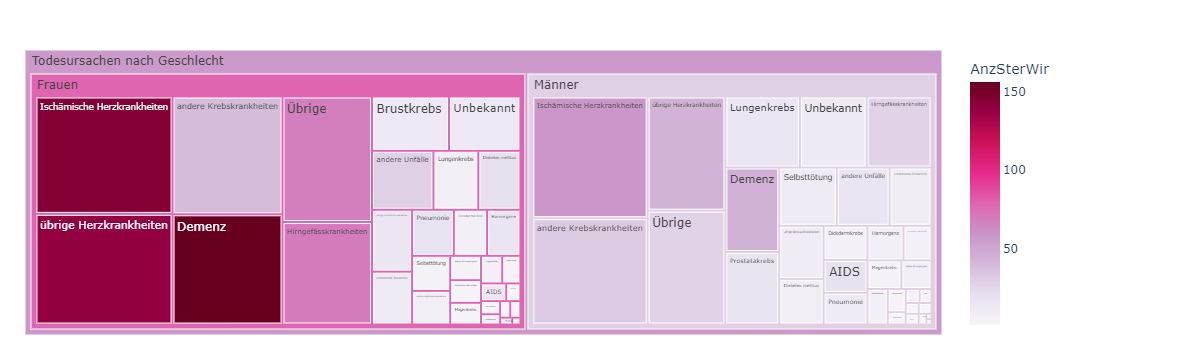

In [86]:
df = mySelYears
fig = px.treemap(df, path=[px.Constant("Todesursachen nach Geschlecht"), 'Geschlecht','Todesursache'], values='AnzSterWir',
                color='AnzSterWir', hover_data=['Todesursache'],
                color_continuous_scale='PuRd')
                #color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir']))
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()


In [87]:
fig.write_html("C:/Users/sszsim/Downloads/todesfaelle_detailliert_geschlecht_ursachen.html")

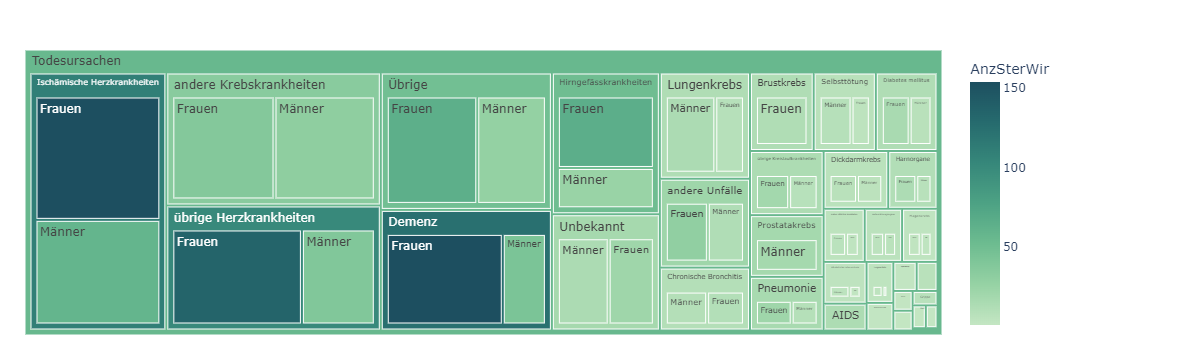

In [88]:
df = data2betested
fig = px.treemap(df, path=[px.Constant("Todesursachen"), 'Todesursache', 'Geschlecht'], values='AnzSterWir',
                color='AnzSterWir', hover_data=['Todesursache'],
                color_continuous_scale='blugrn')
                #color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir']))
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()



In [89]:
fig.write_html("C:/Users/sszsim/Downloads/todesfaelle_detailliert_ursachen_geschlecht.html")

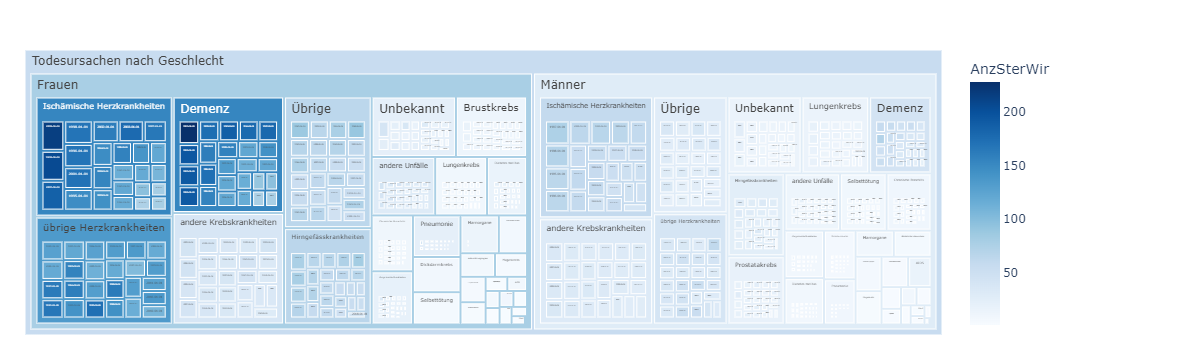

In [90]:
df = data2betested
fig = px.treemap(df, path=[px.Constant("Todesursachen nach Geschlecht"), 'Geschlecht', 'Todesursache', 'StichtagDatJahr'], values='AnzSterWir',
                color='AnzSterWir', hover_data=['Todesursache'],
                color_continuous_scale='blues')
                #color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir']))
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()


In [91]:
fig.write_html("C:/Users/sszsim/Downloads/todesfaelle_detailliert_geschlecht_ursachen_jahr.html")

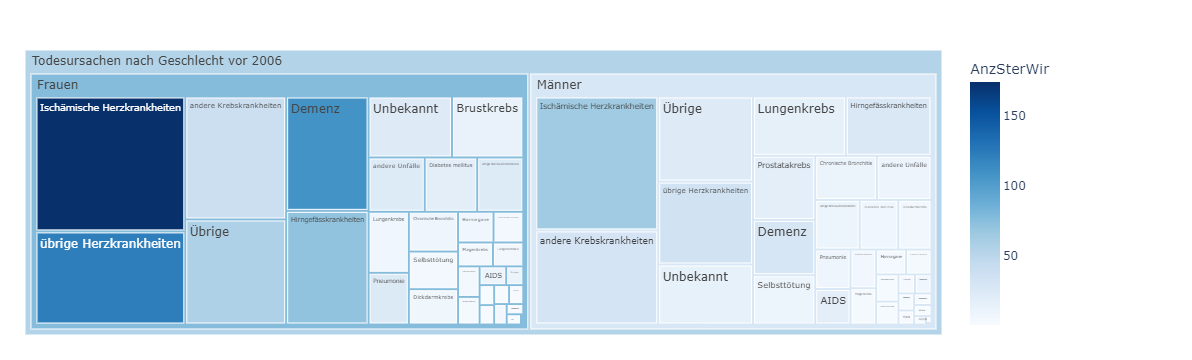

In [92]:
df = mySelYearsVor2006
fig = px.treemap(df, path=[px.Constant("Todesursachen nach Geschlecht vor 2006"), 'Geschlecht', 'Todesursache'], values='AnzSterWir',
                color='AnzSterWir', hover_data=['Todesursache'],
                color_continuous_scale='blues')
                #color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir']))
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()


In [93]:
fig.write_html("C:/Users/sszsim/Downloads/todesfaelle_detailliert_geschlecht_ursachen_vor2006.html")

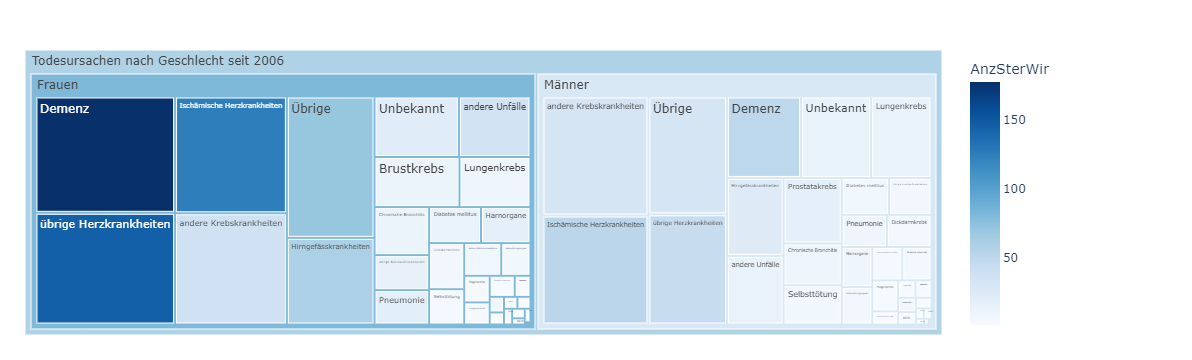

In [94]:
df = mySelYearsSeit2006
fig = px.treemap(df, path=[px.Constant("Todesursachen nach Geschlecht seit 2006"), 'Geschlecht', 'Todesursache'], values='AnzSterWir',
                color='AnzSterWir', hover_data=['Todesursache'],
                color_continuous_scale='blues')
                #color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir']))
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [95]:
fig.write_html("C:/Users/sszsim/Downloads/todesfaelle_detailliert_geschlecht_ursachen_seit2006.html")

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [29]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

In [30]:
mySelYears = data2betested[(data2betested.StichtagDatJahr == "2019")]


In [31]:
#myGraph= mySelYears[['TodesursacheSpezSort','TodesursacheSpezLang', 'AlterVSort_Nam', 'AnzSterWir']]
myGraph= mySelYears.groupby(['TodesursacheSort','Todesursache', 'AlterVSort_Nam'])['AnzSterWir'].sum()
myGraph

TodesursacheSort  Todesursache  AlterVSort_Nam
102               AIDS          1 – 14             0
                                15 – 29            0
                                30 – 44            0
                                45 – 59            1
                                60 – 64            0
                                                  ..
1300              Unbekannt     70 – 74           18
                                75 – 79           27
                                80 – 84           16
                                85 und älter      53
                                unter 1            0
Name: AnzSterWir, Length: 352, dtype: int64

In [32]:
myGraph.dtypes
murders = data2betested[(data2betested.Todesursache == "AIDS")]
murders

,StichtagDatJahr,Todesursache,TodesursacheSort,AlterVSort_Num,AlterVSort_Nam,AnzSterWir,Geschlecht
0,1995-01-01,AIDS,102,1,unter 1,0,Frauen
1,1995-01-01,AIDS,102,2,1 – 14,0,Frauen
2,1995-01-01,AIDS,102,3,15 – 29,2,Frauen
3,1995-01-01,AIDS,102,4,30 – 44,20,Frauen
4,1995-01-01,AIDS,102,5,45 – 59,2,Frauen
...,...,...,...,...,...,...,...
16110,2019-01-01,AIDS,102,7,65 – 69,0,Männer
16111,2019-01-01,AIDS,102,8,70 – 74,0,Männer
16112,2019-01-01,AIDS,102,9,75 – 79,0,Männer
16113,2019-01-01,AIDS,102,10,80 – 84,0,Männer


In [33]:
# df_statzonen = df_statzonen[(df_statzonen.knr>0) & (df_statzonen.qname!="Hirslanden")]
#aktuellesJahr[[aktuellesJahr.KreisSort =7]] 


highlight = alt.selection(type='single', on='mouseover',
                          fields=['StichtagDatJahr'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(murders).encode(
    x='StichtagDatJahr',
    y='AnzSterWir',
    color='Todesursache'
)

points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=700 , height=500
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1.5), alt.value(4))
).interactive()

points + lines


alt.LayerChart(...)

In [34]:
alt.Chart(mySelYears).mark_circle(size=60).encode(
    x='AlterVSort_Nam',
    y='AnzSterWir',
    color='Todesursache',
    tooltip=['AlterVSort_Nam','AnzSterWir']
).interactive() # this makes the axes interactive: now you can zoom & pan


alt.Chart(...)

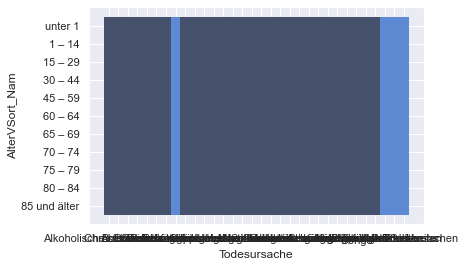

In [35]:
import seaborn as sns
sns.set(style="darkgrid")
sns.histplot(data=mySelYears, x="Todesursache", y="AlterVSort_Nam") #, y="Nachname")
plt.show();